## Yoni Levine and Farhad Zmarai
 

In [2]:
#Scraper imports
from IPython.display import Video

from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from time import sleep
import warnings


#Data processing/feature engineering imports
import matplotlib.pyplot as plt
import numpy as np
from readability import Readability
import spacy
import multiprocessing
from ipywidgets import FloatProgress
from collections import Counter
import string
from nltk import word_tokenize
from nltk.corpus import stopwords


#Text Visualizations imports
import math

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import string
import bokeh
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource, Slope, Label
from bokeh.io import output_notebook
import seaborn as sns

output_notebook()

# Modeling imports
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score




warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
cores = multiprocessing.cpu_count()
stopwords = set(stopwords.words("english"))



Loading BokehJS ...

# CIS 5450 Final Project: Mental Health Classification
The objective of this project is to study takethislife.com, a forum dedicated to support of users dealing with depression, and help understand what factors are associated with suicidal ideation. The website is split into two separate forums, one for depression and one for suicidal ideation. We want to see if we can use the text and usernames from the depression forum to predict which users will also post in the forum for suicidal ideation. We are viewing this as a binary classifcation problem, where a post is labeled with a 1 if the author of that post had also posted in the suicide forum, 0 elsewise. 

# Data Acquisition
We start off by scraping the data using Selenium and parsing the HTML using beautifulSoup. Depression and suicide forum data are scraped separately and exported to csv files. 

In [ ]:
# instantiate web driver
driver = webdriver.Chrome(executable_path="./chromedriver")

In [ ]:
# password Finalprojectlogin123!@#
# email ylevine@seas.upenn.edu
# username ylfz

# login process to remove ads
driver.get("http://www.takethislife.com")    

username = driver.find_element_by_xpath("""//*[@id="navbar_username"]""")
password = driver.find_element_by_xpath("""//*[@id="navbar_password"]""")

username.send_keys("ylfz")
password.send_keys("Finalprojectlogin123!@#")

driver.find_element_by_xpath("""/html/body/div[1]/div/div/table[1]/tbody/tr/td[2]/form/table/tbody/tr[2]/td[3]/input""").click()
sleep(10)

## Depression Forum Scraper

In [2]:
#head to the last post in the depression forum (as of 07/19)
driver.get("https://www.takethislife.com/depression/do-you-ever-feel-like-everyone-290674/")

In [ ]:
#create empty DF to load our posts into
depression= pd.DataFrame(columns=["username","text","posts","url","date_posted"])

In [ ]:
# 968 pages of 20 posts each
total_posts = 20 * 968
htmls = []

In [5]:
for item in range(total_posts):
    try:
        #get full page HTML
        html = driver.page_source

        #parse structure using BS
        html2=BeautifulSoup(html,'html.parser', from_encoding="utf-8")
        htmls.append(html2)

        #get initial post from each forum thread
        text=html2.find("div", id=re.compile("^post_message")).get_text()

        #get username
        name=html2.find('a',class_='bigusername').get_text()

        #get post count section and parse posts
        q = html2.find("div", id="posts").get_text()
        p = re.search('Posts: (\d+)',q.replace(',',''))
        posts=p[0].split(' ')[-1]

        #get current page URL
        url = driver.current_url

        #get date posted
        date_raw = driver.find_element_by_xpath("""/html/body/table[2]/tbody/tr/td[1]/div/div[1]/div/div/div/table/tbody/tr[1]/td[1]""").text

        if 'today' in date_raw.lower():
            now = datetime.utcnow()
            date_raw = datetime.strftime(now, '%Y-%m-%d, %H:%M:%S')

        if 'yesterday' in date_raw.lower():
            now = datetime.utcnow() - timedelta(days=1)
            date_raw = datetime.strftime(now, '%Y-%m-%d, %H:%M:%S')
            

        # save info to DF
        depression.loc[len(depression)]=[name, text, posts, url, date_raw]
        sleep(.5)

        #Proceed to next post
        driver.find_element_by_xpath("""/html/body/div[3]/div/div/div[1]/a""").click()

        print(f'{len(depression)}/{total_posts}',end='\r')
    except Exception as e:
        driver.find_element_by_xpath("""/html/body/div[3]/div/div/div[1]/a[1]""").click()
        print(f'Skipping url {url} item number {item}')
driver.close()


depression.to_csv('depression_raw.csv',index=None)

## Suicide Forum Scraper

In [10]:
driver.get("https://www.takethislife.com/suicide/do-i-have-balls-go-through-290606/")

In [ ]:
total_posts = 20 * 453
htmls = []

In [ ]:
suicide = pd.DataFrame(columns=["username","text","posts","url","date_posted"])

In [ ]:

for item in range(total_posts):
    try:
        #get full page HTML
        html = driver.page_source

        #parse structure using BS
        html2=BeautifulSoup(html,'html.parser', from_encoding="utf-8")
        htmls.append(html2)

        #get initial post from forum
        text=html2.find("div", id=re.compile("^post_message")).get_text()

        #get username
        name=html2.find('a',class_='bigusername').get_text()

        #get post count section and parse posts
        q = html2.find("div", id="posts").get_text()
        p = re.search('Posts: (\d+)',q.replace(',',''))
        posts=p[0].split(' ')[-1]

        #get current page URL
        url = driver.current_url

        #get date posted
        date_raw = driver.find_element_by_xpath("""/html/body/table[2]/tbody/tr/td[1]/div/div[1]/div/div/div/table/tbody/tr[1]/td[1]""").text

        if 'today' in date_raw.lower():
            now = datetime.utcnow()
            date_raw = datetime.strftime(now, '%Y-%m-%d, %H:%M:%S')

        if 'yesterday' in date_raw.lower():
            now = datetime.utcnow() - timedelta(days=1)
            date_raw = datetime.strftime(now, '%Y-%m-%d, %H:%M:%S')
            

        #Proceed to next post
        driver.find_element_by_xpath("""/html/body/div[3]/div/div/div[1]/a""").click()
        suicide.loc[len(suicide)]=[name, text, posts, url, date_raw]
        sleep(.5)
        print(f'{len(suicide)}/{total_posts}',end='\r')
    except Exception as e:
        driver.find_element_by_xpath("""/html/body/div[3]/div/div/div[1]/a[1]""").click()
        suicide.loc[len(suicide)]=[name, text, posts, url, date_raw]
        sleep(.5)
        print(f'{len(suicide)}/{total_posts}',end='\r')
        
driver.close()

suicide.to_csv('suicide_raw.csv',index=None)

In [166]:
#Selenium browser in action
Video("Screen Recording 2022-07-20 at 12.09.51 AM.mp4",width=576, height=1024)


# Data Exploration/Visualiztion and Feature Engineering
Now that we have the data, we can begin our EDA and understand what our data looks like using summary statistics and basic visualizations. <br> In addition we will create several features from the data itself that may help our model in the future.

In [3]:
depression = pd.read_csv('https://www.dropbox.com/s/dsxdhwztitydwdg/depression_raw.csv?dl=1')

In [4]:
depression.head()

,username,text,posts,url,date_posted
0,ayoubalharchal,\n\n\nDo you ever feel like everyone is watchi...,8,https://www.takethislife.com/depression/do-you...,"07-19-22, 02:47 PM"
1,ayoubalharchal,\n\n\nDo you compare yourself to other people ...,8,https://www.takethislife.com/depression/do-you...,"07-14-22, 05:15 PM"
2,ayoubalharchal,\n\n\nDo you find yourself apologizing all the...,8,https://www.takethislife.com/depression/do-you...,"07-14-22, 08:34 AM"
3,ayoubalharchal,"\n\n\nIF SO, READING & UNDERSTANDING THIS WILL...",8,https://www.takethislife.com/depression/do-you...,"07-12-22, 05:00 PM"
4,ayoubalharchal,\n\n\nAren’t you a little bit tired of people ...,8,https://www.takethislife.com/depression/aren-t...,"07-12-22, 07:56 AM"


In [5]:
depression.dtypes

username       object
text           object
posts           int64
url            object
date_posted    object
dtype: object

In [6]:
depression.describe()
# The numbers are highly skewed as the users with the most posts appear the most frequently in the data frame. 
# Will manually calculate the mean and median posts per user

,posts
count,19328.000000
mean,1230.330608
std,2691.801545
min,0.000000
25%,8.000000
50%,87.000000
75%,939.000000
max,18210.000000


In [7]:
# Calculating the average post per user by using the max number of posts per unique user in the DF
user_post_count = pd.DataFrame(depression.groupby('username')['posts'].max()).sort_values('posts')
user_post_count

,posts
username,
JustBreathe,0
mr201,1
UK20101982,1
HelpMeNowPlease,1
HelpMe22,1
...,...
irishred,11944
Blue Girl,13622
Road Ratt,13622


In [8]:
mean = np.mean(user_post_count['posts'])
median = np.median(user_post_count['posts'])
print(f"The average number of posts per user is {mean} and the median is {median}.")

The average number of posts per user is 105.58227323008849 and the median is 4.0.


In [27]:
depression.isna().sum()
#username was actually "nan" 

username       1
text           0
posts          0
url            0
date_posted    0
dtype: int64

In [29]:
#standardizing usernames
depression['username_clean'] = [str(d).lower().replace(' ','_') for d in depression['username']]
#setting # of posts to integer
depression['posts'] = pd.to_numeric(depression['posts'])
#setting datetime
depression['date_posted'] = [datetime.strptime(d, '%m-%d-%y, %H:%M %p').date() for d in depression['date_posted']]

In [30]:
depression.shape

(19328, 6)

In [ ]:
#remove posts with less than 30 chars
depression = depression[depression['text'].apply(lambda x: len(str(x))>=30)]
#remove users for which posts showed up as 0
depression = depression[depression['posts']>=1]
#remove posts which users posted twice (different url so not dropped with regular dedupe)
depression = depression.drop_duplicates(subset=['text','username_clean'])

# Creating shallow features from the post text

In [31]:
#building some shallow features from the posts
depression['post_length'] = [len(post) for post in depression['text']]
depression['word_count'] = [len(post.split(' ')) for post in depression['text']]

In [35]:
def readability_score(text):
    try:
        r = Readability(text)
        f = r.flesch()
        return f.score
    except:
        return None

In [36]:
#using the flesch readabilty score as a feature, higher score means more readability
depression['readability_score'] = depression['text'].apply(lambda x : readability_score(x))

# Adding parts-of-speech tagging to augment our features
Seeing if we can add POS tags, such as whether users speak in past tense, or use lots of adverbs, and turn those into features for our data.

In [39]:
nlp = spacy.load('en_core_web_sm')

def get_pos_tags(text):
    doc = nlp(text)
    return [(token.pos_, token.tag_) for token in doc]

In [40]:
depression = depression.reset_index(drop=True)

In [42]:
tags = []
texts = depression['text']
for i in range(len(texts)):
    print(f'{i}/19154',end='\r')
    post = texts[i]
    tags.append(get_pos_tags(post))

In [43]:
depression['pos_tags'] = tags

In [44]:
# Joining pos and detail tag
all_joined = []
for index, row in depression.iterrows():
    t = []
    raw_tags = row['pos_tags']
    for tup in raw_tags:
        joined_tags = '_'.join(tup)
        t.append(joined_tags)
    all_joined.append(t)

depression['joined_tags'] = all_joined

In [45]:
#Calculating ratios of POS_tags per post
tag_dicts = []
for t in depression['joined_tags']:
    c = Counter(t)
    sc = [(i, round(c[i] / len(t) * 100.0,2)) for i in c]
    scd = dict(sc)
    tag_dicts.append(scd)
depression['tag_ratios'] = tag_dicts

In [46]:
# Exploding pandas column of dictionaries into seperate columns
depression = pd.concat([depression.drop(['tag_ratios'], axis=1), depression['tag_ratios'].apply(pd.Series)], axis=1)

# Suicidal Forum Data Exploration
#### This data isn't of that much use to us because we're only going to use it to <br> label our training data, but will be interesting to explore.

In [47]:
suicide = pd.read_csv('https://www.dropbox.com/s/ilphpbm9mrrro2o/suicide_raw.csv?dl=1')

In [48]:
suicide.head()

,username,text,posts,url,date_posted
0,BigD93,\n\n\nSo as I've mentioned. I've been a member...,428,https://www.takethislife.com/suicide/do-i-have...,"05-15-22, 06:21 PM"
1,Carlos99,\n\n\nDoes anyone know the best way to kill yo...,1,https://www.takethislife.com/suicide/suicide-2...,"06-20-22, 02:07 PM"
2,Tesmeralda,"\n\n\nHey everyone, I want to kill myself. \n...",1,https://www.takethislife.com/suicide/feeling-s...,"06-09-22, 04:54 AM"
3,Mirk,\n\n\nI want to kill myself and I don't care a...,1,https://www.takethislife.com/suicide/idgaf-abt...,"05-20-22, 03:21 AM"
4,Raven'',"\n\n\nHello. \nI don't want you to worry, I do...",2,https://www.takethislife.com/suicide/should-i-...,"02-16-22, 10:42 PM"


In [49]:
user_post_count = pd.DataFrame(suicide.groupby('username')['posts'].max()).sort_values('posts')
user_post_count

,posts
username,
*Bill*,1
infinitioirritus,1
indiana,1
JustLetMeGo,1
JustTryinToHelp,1
...,...
Strawbean,11024
irishred,11944
silent cry,18210


In [50]:
mean = np.mean(user_post_count['posts'])
median = np.median(user_post_count['posts'])
print(f"The average number of posts per user is {mean} and the median is {median}.")

The average number of posts per user is 163.3965379494008 and the median is 5.0.


In [51]:
#getting usernames into same format that we had it in for depression data
suicide['username'] = [str(d).lower().replace(' ','_') for d in suicide['username']]

In [52]:
suicidal = set(suicide['username'].unique())
depressed = set(depression['username_clean'].unique())

# Depression Text Cleaning and NLP Preprocessing
This section includes producing clean data by performing text manipulation techniques. Basically, the input data is converted to lower case, cleaned of punctuations, numbers, stopwords and urls, and converted to root forms.

In [53]:
depression['clean_text'] = depression['text']

In [54]:
def removeNonEnglishChars(text):
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [55]:
depression['clean_text'] = depression['clean_text'].map(removeNonEnglishChars)

In [56]:
def lowerCase(text):
    text = text.lower()
    return text

def removePunctuation(text):
    text  = ''.join([char for char in text if char not in string.punctuation])
    return text

def removeNumbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

def removeStopwords(text):
    res = []
    for word in text.split():
        if word not in stopwords:
            res.append(word)
    return ' '.join(res)

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text

def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)
    return text

def cleanText(text,remove_stop = True):
    text = remove_urls(text)
    text = remove_emails(text)
    text = lowerCase(text)
    text = removePunctuation(text)
    text = removeNumbers(text)
    if remove_stop:
        text = removeStopwords(text)
    return text

In [57]:
depression['clean_text'] = depression['clean_text'].map(cleanText)

In [58]:
# Lemmatizing will merge multiple forms and tenses of a word into its root form
# for example running and ran == run
def lemmatizerPipe(texts):
    lemmatized = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"],n_process=cores-1):
        lemmatized.append(" ".join([token.lemma_ for token in doc]))
    return lemmatized

In [59]:
depression['clean_text'] = lemmatizerPipe(depression['clean_text'])

In [60]:
#Labeling our depression data
depression['suicidal'] = [1 if name in suicidal else 0 for name in depression['username_clean']]

depression.to_csv('depression_full.csv',index=None)

In [61]:
depression_full = pd.read_csv('https://www.dropbox.com/s/zrhxad0zoiuaovr/depression_full.csv?dl=1')

In [62]:
#getting rid of some columns that we don't need anymore
depression_full.drop(columns=['username','pos_tags', 'joined_tags','url','post_length'],inplace=True)
depression_full = depression_full.rename(columns = {'username_clean':'username'})

The following visualizations provide interesting insights before we move on to using our modeling phase.

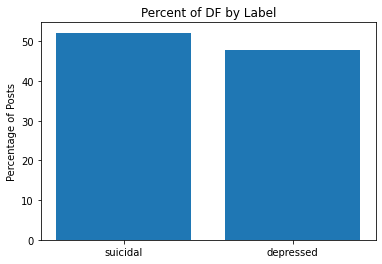

In [63]:
x = ['suicidal','depressed']
y = [round((len(depression_full[depression_full['suicidal']==1])/len(depression_full)*100),2),round((len(depression_full[depression_full['suicidal']==0])/len(depression_full)*100),2)]
plt.ylabel('Percentage of Posts')
plt.title('Percent of DF by Label')
plt.bar(x,y)
plt.show()

The classes are relatively balanced with suicidal authors class containing 52%.

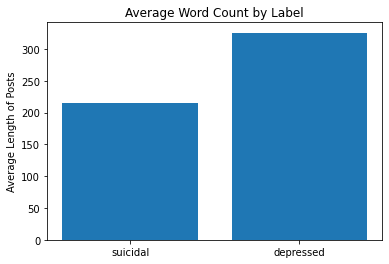

In [65]:
x = ['suicidal','depressed']
y = [depression_full[depression_full['suicidal']==1]['word_count'].mean(),depression_full[depression_full['suicidal']==0]['word_count'].mean()]
plt.ylabel('Average Length of Posts')
plt.title('Average Word Count by Label')
plt.bar(x,y)
plt.show()

The average word count is around 30% lower for posts written by suicidal users vs depressed users. Suicidal users also tend to post with less formal language.

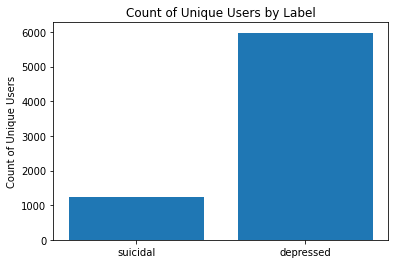

In [66]:
x = ['suicidal','depressed']
y = [len(depression_full[depression_full['suicidal']==1]['username'].unique()),len(depression_full[depression_full['suicidal']==0]['username'].unique())]
plt.ylabel('Count of Unique Users')
plt.title('Count of Unique Users by Label')
plt.bar(x,y)
plt.show()

While the number of posts in each class is relatively the same, there are far more unique users in the depression class. However, as you can see in the next chart <br>  suicidal users post far more than depressed users. Note that these post numbers in the chart below reflect the  total number of posts that the users made on the entire website,<br> which includes responese to other posts and posts in other forums that are not depression or suicide.

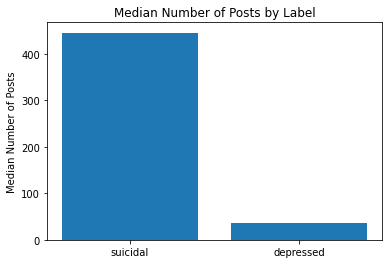

In [67]:
x = ['suicidal','depressed']
y = [pd.DataFrame(depression_full[depression_full['suicidal']==1].groupby('username')['posts'].max()).sort_values('posts')['posts'].mean(),pd.DataFrame(depression_full[depression_full['suicidal']==0].groupby('username')['posts'].max()).sort_values('posts')['posts'].mean()]
plt.ylabel('Median Number of Posts')
plt.title('Median Number of Posts by Label')
plt.bar(x,y)
plt.show()

In [68]:
depression_date = depression_full.copy()
depression_date["date_posted"] = depression_date["date_posted"].astype("datetime64")
depression_date = depression_date.set_index("date_posted")

The following chart indicates number of posts per month on the forum. It is interesting to see the number of posts had a fall right around 2008 and a sharp increase afterward.

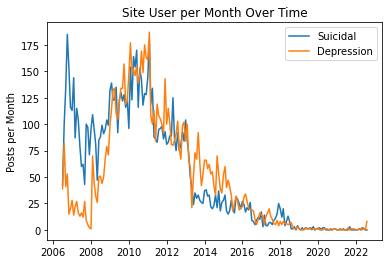

In [69]:
x = depression_date[depression_date['suicidal']==0].groupby(pd.Grouper(freq='M')).count().index
y_s =  depression_date[depression_date['suicidal']==1].groupby(pd.Grouper(freq='M')).count()['posts'] 
y_s['2022-06-30'] = 0
y_s['2022-07-31'] = 0
y_d =  depression_date[depression_date['suicidal']==0].groupby(pd.Grouper(freq='M')).count()['posts']
plt.plot(x, y_s, label = "Suicidal")
plt.plot(x, y_d, label = "Depression")
plt.ylabel('Posts per Month')
plt.title('Site User per Month Over Time')
plt.legend()
plt.show()

In [70]:
#removing, highly corelated 
depression_full.drop(columns=['readability_score'],inplace=True)

In [71]:
depression_full.dropna(subset=['username','text','clean_text'],inplace=True)

In [73]:
depression_full['date_posted'] = [datetime.strptime(datetime_str, '%Y-%m-%d') for datetime_str in depression_full['date_posted']]

In [74]:
# creating feature for day of week that post was created
depression_full['day_of_week'] = [date.isoweekday() for date in depression_full['date_posted']]

In [75]:
depression_full['text'] = depression_full['text'].apply(lambda x:cleanText(x,remove_stop=False))

In [76]:
# fill null pos tags with zero
depression_full = depression_full.fillna(0)

In [77]:
# We created to DF one with stopwords (common words like and, is, or) removed
#and one with the stopwords for our modeling

depression_full.to_csv('modeling_with_stopwords.csv',index=None)

# Text Visualizations
## Word Clouds

A glance at the following word clouds suggests that words used by users with suicidal ideation tend to be associated with anger, while depressed users mainly express themselves using emotional words.

In [78]:
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

In [80]:
df = pd.read_csv('https://www.dropbox.com/s/inkzg6vb5cnnz5c/modeling.csv?dl=1')
df = df.rename(columns = {'posts':'posts_from_user','suicidal':'user_is_suicidal'})

In [81]:
stokens = []
dtokens = []
for i,r in df.iterrows():
    token = r['text'].split(' ')
    if r['user_is_suicidal']==1:
        stokens.extend(token)
    else:
        dtokens.extend(token)
dtoken_count = Counter(dtokens)
stoken_count = Counter(stokens)

Text(0.5, 1.0, 'Suicidal Word Cloud')

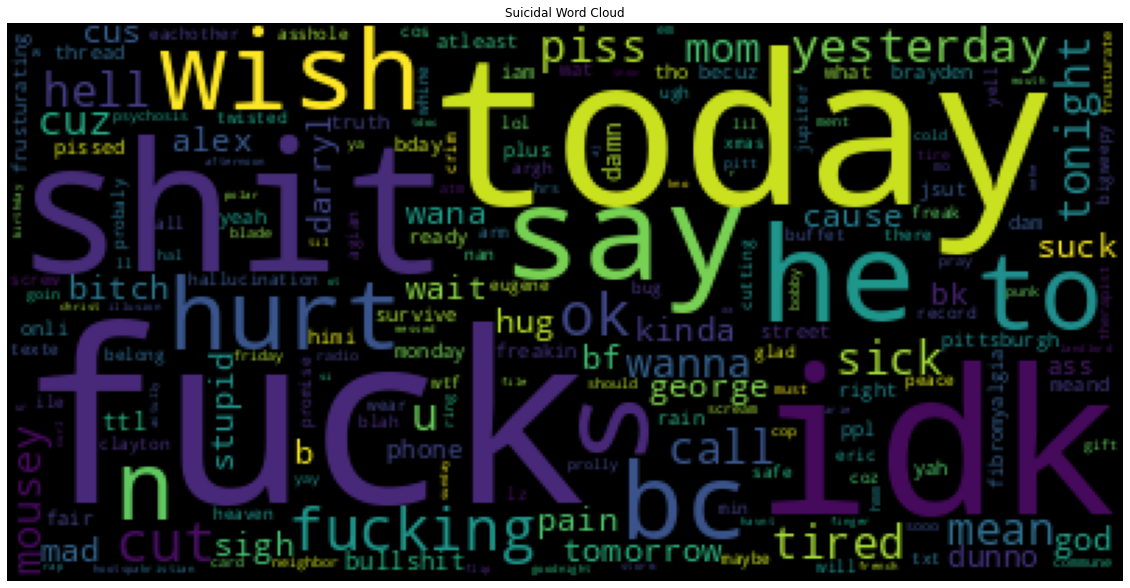

In [84]:
s_word_cloud = stoken_count - dtoken_count 
wc_top = WordCloud().generate_from_frequencies(s_word_cloud)
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_top)
plt.title('Suicidal Word Cloud')

Text(0.5, 1.0, 'Depression Word Cloud')

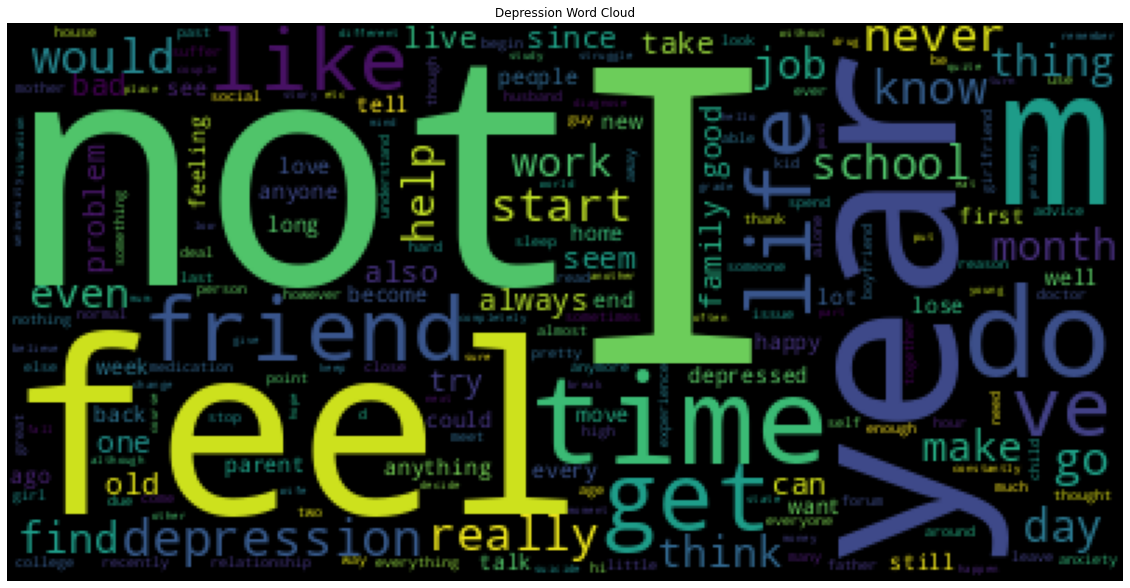

In [85]:
d_word_cloud = dtoken_count - stoken_count 
wc_top = WordCloud().generate_from_frequencies(d_word_cloud)
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(wc_top)
plt.title('Depression Word Cloud')

## NLP class word differentiation and frequency visualiztion

In [145]:
df_s = df[df['user_is_suicidal']==1]
df_d = df[df['user_is_suicidal']==0]

# using min_df = 10 to ignore terms that occur in less than 10 documents for memory reasons
# you can also set a max df as a float, e.g .5 will exclude terms tad occur in > 50% of documents

#true class tfidf vectorizing
cvt = TfidfVectorizer(ngram_range=(1,1),min_df=10)

X_all = cvt.fit_transform(df_s['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_s['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

s_tfidf_ngram = X.sum(axis=0)

# false class tfidf vectorizing
cvt = TfidfVectorizer(ngram_range=(1,1),min_df=10)
X_all = cvt.fit_transform(df_d['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_d['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

d_tfidf_ngram = X.sum(axis=0)

# true class count vectorizing
cvt = CountVectorizer(ngram_range=(1,1),min_df=10)

X_all = cvt.fit_transform(df_s['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_s['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

s_count_ngram = X.sum(axis=0)

# fake count vectorizing
cvt = CountVectorizer(ngram_range=(1,1),min_df=10)
X_all = cvt.fit_transform(df_d['text'].apply(lambda x: np.str_(x)))

X = pd.DataFrame(cvt.transform(df_d['text'].values.astype('U')).todense(),columns = cvt.get_feature_names())

d_count_ngram = X.sum(axis=0)


In [146]:
#creating data frame with tfidf values
true = pd.DataFrame(s_tfidf_ngram,columns=['true_tfidf'])
fake = pd.DataFrame(d_tfidf_ngram,columns=['fake_tfidf'])

#adding count values
true['true_count'] = s_count_ngram
fake['fake_count'] = d_count_ngram

#adding log scale of tfidf. You can add an offset to the result to account for negative values
#that occur when your TFIDF is between 1 and 0
true['true_log'] = [math.log(result) + 3 for result in true['true_tfidf']]
fake['fake_log'] = [math.log(result) + 3 for result in fake['fake_tfidf']]

In [147]:
full_joined = true.join(fake,how='outer')
full_joined = full_joined.fillna(0)
full_joined['word'] = full_joined.index
joined = full_joined[(full_joined.true_count > 10) | (full_joined.fake_count > 10) ]

In [148]:
# Function to label chart
def addManualLabel(word, x, y):
    mytext = Label(x = x, y = y, text = word.capitalize(),\
        text_font_size = '10pt', text_font_style = 'bold')
    
    p.add_layout(mytext)

In [149]:
#defining fake and true keywords
#first run the chart decide what words you want to label and 
#add them to the correct list then rerun the cell below

s_keywords = ['shit','fuck','idk','hurt','think']
d_keywords = ['wellbutrin','intimate','currently','thanks','exwife','therapy']

In [167]:
#defining data source
df_source = ColumnDataSource(joined)

#defining figure, title for chart and axes, and plot size
p = figure(title = "Difference in word usage between posts in Suicide and Depression",\
    x_axis_label = "Word Usage in Depression",\
    y_axis_label =  "Word Usage in Suicide")

p.scatter(x = "fake_log", y = "true_log", source = df_source,\
    fill_color = "blue", fill_alpha = .4)
#chart popups
hover = HoverTool()

hover.tooltips = [
    ("Word","@word"), #popup label and @columnname
    ("Depression Count", "@fake_count"),
    ("Suicide Count", "@true_count")
]

p.add_tools(hover)

#creating sloped line
gradient = 1
y_intercept = 0

slope = Slope(gradient = gradient, y_intercept = y_intercept,\
    line_color = 'black', line_dash = 'dashed', line_width = 3.5)


p.add_layout(slope)

#adding labels

#if the chart throws an error at this point uncomment the print statement and see
#which word is throwing the error 

for index, row in joined.loc[s_keywords].iterrows():
    # print(row['word'],row['true_log'], row['fake_log'])
    
    mytext = Label(x = row['fake_log'], y = row['true_log'],\
        text = row['word'].capitalize(), text_font_size = '10pt',\
        text_font_style = 'bold')

    p.add_layout(mytext)

for index, row in joined.loc[d_keywords].iterrows():
    # print(row['word'],row['true_log'], row['fake_log'])
    
    mytext = Label(x = row['fake_log'], y = row['true_log'],\
        text = row['word'].capitalize(), text_font_size = '10pt',\
        text_font_style = 'bold')

    p.add_layout(mytext)

# you can add manual labels for a word for stylistic reasons
# addManualLabel("manual test",9,4)


#adding large labels
mytext = Label(x = 6, y = .5, text = "Depression",\
    text_font_size = '24pt', render_mode = "canvas")

p.add_layout(mytext)

mytext = Label(x = 0, y = 8, text = "Suicide",\
    text_font_size = '24pt', render_mode = "canvas")

p.add_layout(mytext)


This chart uses space in two ways: <br> 
1. The further away a word is from the center line the more exclusive it is the that class, and the more useful it may be.
2. The higher/lower the word is on the center line the more/less frequent it is used. 
<br> <br>
For example, the word idk is used more exclusively by the suicidal class, but not as frequently the f-word is. The word Wellbrutin is among the most exclusive word in the depression class as it is a common treatment. The term think is one of the most frequently used words, but is very close to the line indicating that it is used by both classes nearly equally. Words located directly on the x and y axis, are used exclusively by that class.

In [169]:
show(p)

In [152]:
output_file("class_usage_chart.html")

save(p)

'/Users/yonilevine/Desktop/Penn_SEAS_MCIT/BigDataMCIT5450/Big_Data_Homework/MCIT545-Final-Project/class_usage_chart.html'

In [154]:
#This plot will not render in Github becuase it uses JS. View the class_usage_chart.html file if you dont want to run this section.

# Modeling and NLP
The process we followed for creating our model was to compare a number of well known machine learning models and select the ones which give us the best results. Our top performers were Logistic Regression and Random Forest. Once we identified these, we ran model tuning using grid search and selected the best hyperparameters.

In [104]:
df = pd.read_csv('https://www.dropbox.com/s/inkzg6vb5cnnz5c/modeling.csv?dl=1')
dfsw = pd.read_csv('https://www.dropbox.com/s/ye1qsevhhmat9kx/modeling_with_stopwords.csv?dl=1')
df = df.rename(columns = {'posts':'posts_from_user','suicidal':'user_is_suicidal'})
dfsw = dfsw.rename(columns = {'posts':'posts_from_user','suicidal':'user_is_suicidal'})

In [105]:
df.head(5)

,text,posts_from_user,word_count,day_of_week,SPACE__SP,AUX_VBP,PRON_PRP,ADV_RB,VERB_VB,SCONJ_IN,PRON_NN,AUX_VBZ,VERB_VBG,PUNCT_.,CCONJ_CC,VERB_VBP,PART_TO,PRON_WP,AUX_MD,AUX_VB,ADP_IN,PRON_PRP$,NOUN_NN,ADJ_JJ,PROPN_NNP,NOUN_NNS,ADP_RP,"PUNCT_,",VERB_VBN,PUNCT_``,NUM_CD,PART_RB,DET_DT,SCONJ_WRB,VERB_VBZ,AUX_VBD,PRON_EX,VERB_VBD,PUNCT_:,PUNCT_'',PUNCT_HYPH,ADJ_JJS,PRON_WDT,PRON_DT,PUNCT_-LRB-,PUNCT_-RRB-,PART_POS,X_LS,ADJ_JJR,ADV_RBR,PUNCT_NFP,INTJ_UH,DET_PDT,AUX_VBG,ADV_RBS,X_XX,X_ADD,SYM_SYM,AUX_VBN,DET_WDT,AUX_RB,X_FW,SYM_$,DET_WP$,PROPN_NNPS,AUX_UH,AUX_IN,AUX_POS,ADJ_AFX,AUX_NN,AUX_NNP,VERB_NNP,AUX_NFP,AUX_``,AUX_FW,VERB_MD,AUX_'',VERB_NN,AUX_SYM,AUX_RBR,VERB_POS,AUX_NNS,AUX_CD,AUX_JJ,AUX_ADD,AUX_:,AUX_-LRB-,VERB_NNS,AUX_HYPH,AUX_PRP,ADV_CC,AUX_.,AUX_XX,AUX_WRB,user_is_suicidal
0,ever feel like everyone watch start overthink ...,8,400,2,4.76,2.75,11.36,3.66,6.59,3.30,0.55,1.28,3.48,7.88,1.47,3.66,2.56,1.28,1.65,1.10,4.76,1.47,6.59,4.58,1.65,3.30,0.92,2.56,0.73,2.01,1.47,0.73,3.48,1.65,0.92,0.55,0.18,0.73,0.37,1.65,0.18,0.18,0.37,0.37,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,compare people hate make feel like you re enou...,8,427,4,5.91,1.39,10.43,5.22,6.78,2.96,2.09,1.04,2.61,7.30,2.96,4.87,2.78,0.52,2.26,0.87,6.26,1.04,5.91,5.22,0.17,3.30,0.35,4.70,0.87,0.35,1.22,0.70,3.48,1.04,1.57,0.35,0.00,0.35,0.35,0.35,0.00,0.17,0.17,0.70,0.00,0.00,0.00,0.00,0.17,0.87,0.17,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,find apologize time even thing be not really f...,8,379,4,5.11,2.46,10.80,3.60,6.06,0.76,0.38,1.14,1.70,7.20,3.60,3.79,1.33,0.38,1.70,0.38,5.87,2.65,8.71,4.17,2.46,4.73,0.00,4.17,0.19,0.57,1.14,1.89,3.98,1.52,0.95,0.00,0.00,0.19,0.38,0.57,1.14,0.19,0.76,0.76,0.00,0.00,0.19,0.00,0.19,0.19,0.76,0.19,0.38,0.19,0.19,0.38,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,read understand free soul today ill talk anoth...,8,377,2,5.59,1.12,6.15,3.35,3.35,1.68,0.37,1.30,2.05,5.96,4.84,3.72,1.30,0.37,1.86,1.12,5.03,1.49,10.80,6.89,1.49,2.42,0.19,3.91,1.49,1.68,2.42,0.93,6.89,0.74,0.37,1.30,0.37,0.56,0.74,1.49,0.74,0.00,0.00,1.30,0.56,0.56,0.00,0.00,0.37,0.19,0.00,0.19,0.37,0.00,0.00,0.00,0.19,0.19,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,be not little bit tired people tell think posi...,8,467,2,4.57,1.47,8.65,5.22,7.01,1.96,0.49,0.33,1.31,6.04,3.26,4.57,2.45,0.49,1.96,0.49,6.36,2.28,8.16,5.55,0.82,4.40,0.65,3.43,1.31,1.47,1.47,0.98,4.08,1.14,0.82,0.49,0.49,0.98,0.49,1.14,0.33,0.00,0.82,0.65,0.16,0.16,0.00,0.00,0.16,0.00,0.16,0.33,0.16,0.00,0.00,0.00,0.16,0.00,0.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [107]:
df.isna().sum().sum()


0

This function does a lot of the work in getting the data ready for modeling<br>
Input is our df, <br>
v_type what type of NLP vectorizor you want to use<br>

min/max_ngram is how many tokens you would like to create features for.<br>
For example, for the sentence “The cow jumps over the moon”. If N=2 (known as bigrams), then the ngrams would be:<br>
the cow<br>
cow jumps<br>
jumps over<br>
over the<br>
the moon<br>
<br>
scale is whether or not you want to apply Standard Scaler to the data set<br>

join is whether or not you want to keep the engineered features, such as the pos ratios<br>
<br>
The function will train test split and process your data and return X-train, y_train, X_test, y_test<br>

In [ ]:

def modeling_df(df,v_type='tfidf',min_ngram = 1, max_ngram = 3, scale = True, join = True):

    train, test = train_test_split(df,stratify=df['user_is_suicidal'],test_size=.3, random_state=42)

    if v_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=50, max_df=.60, ngram_range=(min_ngram,max_ngram))
    elif v_type == 'count':
        vectorizer = CountVectorizer(min_df=50, max_df=.60, ngram_range=(min_ngram,max_ngram))
    else:
        raise Exception("v_type must be 'tfidf' or 'count'")
    text_matrix = vectorizer.fit_transform(train['text'])
    word_features = pd.DataFrame(text_matrix.toarray(),columns = vectorizer.get_feature_names()).reset_index(drop=True)
    if join:
        other_features = train.iloc[:, 1:].reset_index(drop=True)
        modeling_features = word_features.join(other_features)
    else:
        modeling_features = word_features
    test_text_matrix = vectorizer.transform(test['text'])
    test_word_features = pd.DataFrame(test_text_matrix.toarray(),columns = vectorizer.get_feature_names()).reset_index(drop=True)
    if join:
        test_other_features = test.iloc[:, 1:].reset_index(drop=True)
        test_modeling_features = test_word_features.join(test_other_features)
    else:
        test_modeling_features = test_word_features
    if join:
        X_train, y_train, X_test, y_test = modeling_features.iloc[:, :-1], modeling_features.iloc[:, -1], test_modeling_features.iloc[:, :-1],test_modeling_features.iloc[:, -1]
    else:
        X_train, y_train, X_test, y_test = modeling_features, train['user_is_suicidal'],  test_modeling_features, test['user_is_suicidal']
    if scale:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train),columns= X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test),columns= X_test.columns)
    return X_train, y_train, X_test, y_test 

In [108]:
# As a general rule for the modeling we are focusing on the F1 score to keep our precission and recall weighted equally

### Count Vectorizor With Logistic Regression

In [ ]:
X_train, y_train, X_test, y_test = modeling_df(df=dfsw, v_type ='count',scale = False)
clf = LogisticRegression(random_state=42, solver='saga').fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))
print("Precision score: {}".format(precision_score(y_test, predictions)))
print("Recall score: {}".format(recall_score(y_test, predictions)))
print("F1 score: {}".format(f1_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.68      0.93      0.79      2749
           1       0.90      0.60      0.72      2996

    accuracy                            0.76      5745
    macro avg       0.79      0.77      0.75      5745
    weighted avg    0.80      0.76      0.75      5745
    
    Precision score: 0.9033066132264529 
    Recall score: 0.6018024032042724 
    F1 score: 0.7223557692307692 

### Count Vectorizor With Logistic Regression and Scaling
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      2749
           1       0.70      0.74      0.72      2996

    accuracy                           0.70      5745
    macro avg       0.70      0.70      0.70     5745
    weighted avg    0.70      0.70      0.70     5745

    Precision score: 0.69717868338558
    Recall score: 0.7423230974632844
    F1 score: 0.7190430003233107

### TFIDF Vectorizor with Logistic Regression
              precision    recall  f1-score   support

           0       0.68      0.93      0.79      2749
           1       0.90      0.60      0.72      2996

    accuracy                           0.76      5745
    macro avg       0.79      0.77     0.76      5745
    weighted avg    0.80      0.76     0.75      5745

    Precision score: 0.9042606516290727
    Recall score: 0.6021361815754339
    F1 score: 0.7229012221999599

### TFIDF Vectorizor with Logistic Regression and Scaling

              precision    recall  f1-score   support

           0       0.74      0.63      0.68      2749
           1       0.70      0.80      0.75      2996

    accuracy                           0.72      5745
    macro avg       0.72      0.71     0.71      5745
    weighted avg    0.72      0.72     0.72      5745

    Precision score: 0.7016720445878557
    Recall score: 0.7983978638184246
    F1 score: 0.7469164715066354

We played around with a lot of different combinations of scaling, ngrams, and joining the engineered features.
Our initial results showed join=False, scale=False, and ngrams 1,3 as our best performers so we stuck with 
those for the most of our models. There are more models in modeling.ipynb

### TFIDF with Multinomial Naive Bayes 

             precision    recall  f1-score   support

           0       0.71      0.64      0.67      2749
           1       0.70      0.77      0.73      2996

    accuracy                           0.70      5745
    macro avg       0.71      0.70     0.70      5745
    weighted avg    0.71      0.70     0.70      5745

    Precision score: 0.6967859308671922
    Recall score: 0.767022696929239
    F1 score: 0.7302192564346996

### TFIDF Vectorizor with SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2749
           1       0.52      1.00      0.69      2996

    accuracy                           0.52      5745
    macro avg       0.26      0.50     0.34      5745
    weighted avg    0.27      0.52     0.36      5745

    Precision score: 0.5214969538729329
    Recall score: 1.0
    F1 score: 0.685505090950692

### TFIDF Vectorizor with Random Forest
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2749
           1       0.80      0.81      0.81      2996

    accuracy                           0.80      5745
    macro avg       0.80      0.80     0.80      5745
    weighted avg    0.80      0.80     0.80      5745

    Precision score: 0.80488610102344
    Recall score: 0.8137516688918558
    F1 score: 0.8092946058091286

#### Our top out-of-box performing models were Logistic Regression and Random Forest. We gridsearched multiple parameters for each model to find the best one.

In [110]:
X_train, y_train, X_test, y_test = modeling_df(df=dfsw, v_type ='tfidf', scale=False)

max_depth = [1,2,3,4,5,6,7,8,9,10, None]
n_estimators = [10,20,30,40,50,60,70,80,90,100]

rf_params = {'max_depth':max_depth, 'n_estimators': n_estimators}

grid_search_cv_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                                rf_params, cv=5, scoring='accuracy')

grid_search_cv_rf.fit(X_train, y_train)

grid_search_cv_rf.best_params_

##### Best parmas for Random Forest
{'max_depth': None, 'n_estimators': 50}

This model was our top performer with an f1-score of 81%

In [ ]:
# Final Random Forest Model
rf = RandomForestClassifier(random_state=42, max_depth= None, n_estimators=50).fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
print(classification_report(y_test, rf_predictions))
print("Precision score: {}".format(precision_score(y_test, rf_predictions)))
print("Recall score: {}".format(recall_score(y_test, rf_predictions)))
print("F1 score: {}".format(f1_score(y_test, rf_predictions)))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      2749
           1       0.81      0.81      0.81      2996

    accuracy                           0.80      5745
    macro avg       0.80      0.80     0.80      5745
    weighted avg       0.80   0.80     0.80      5745

    Precision score: 0.8126675603217158
    Recall score: 0.8094125500667557
    F1 score: 0.8110367892976589

In [ ]:
X_train, y_train, X_test, y_test = modeling_df(df=dfsw, v_type ='tfidf', scale=True)

solver = ['saga']
penalty = ['l2', 'l1', 'elasticnet']
c_values = [0.001, 0.01, 0.1, 1, 10, 100]

lr_params = {'solver': solver, 'penalty': penalty, 'C': c_values}

grid_search_cv_lr = GridSearchCV(estimator = LogisticRegression(random_state=42),
                                param_grid = lr_params, cv=5)

grid_search_cv_lr.fit(X_train, y_train)

grid_search_cv_lr.best_params_

##### Best params for Logistic Regression
{'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}

In [112]:
# Final Logistic Regression Model

clf = LogisticRegression(random_state=42, solver='saga', C=0.001, penalty='l1').fit(X_train, y_train)
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))
print("Precision score: {}".format(precision_score(y_test, predictions)))
print("Recall score: {}".format(recall_score(y_test, predictions)))
print("F1 score: {}".format(f1_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2749
           1       0.83      0.75      0.79      2996

    accuracy                           0.79      5745
    macro avg       0.79      0.79     0.79      5745
    weighted avg    0.79      0.79     0.79      5745

    Precision score: 0.830991124260355
    Recall score: 0.75
    F1 score: 0.788421052631579

# Model Interpretation 

Our top models finished with a 81% F1 score for Random Forest and 79% for Logistic Regression with L1 penalty. The hyperparameter tuning for RF only provided a 1% increase in F1 score, while the tuning for logistic regression provided a 5% increase in F1 score. 

In [3]:
lr_coef = pd.read_csv('https://www.dropbox.com/s/l0tkopj52khiwg4/lr_coef.csv?dl=1')
lr_coef = lr_coef.drop(columns = 'Unnamed: 0')

In [11]:
lr_coef_s = lr_coef[lr_coef['f_coef']>0]
lr_coef_d = lr_coef[lr_coef['f_coef']<0]
top30_s = lr_coef_s.sort_values(by='f_coef',ascending=True)[-30:]
top30_d = lr_coef_d.sort_values(by='f_coef',ascending=True)[:30]
top_60 = pd.concat([top30_d,top30_s])
top_60

,features,f_coef
4913,hi,-0.511334
134,advice,-0.243043
5287,im new,-0.238195
4798,hello,-0.216911
13411,years,-0.208217
8629,partner,-0.197482
2116,cant get,-0.194151
7767,new here,-0.192372
7568,my partner,-0.181047
1103,around me,-0.177336


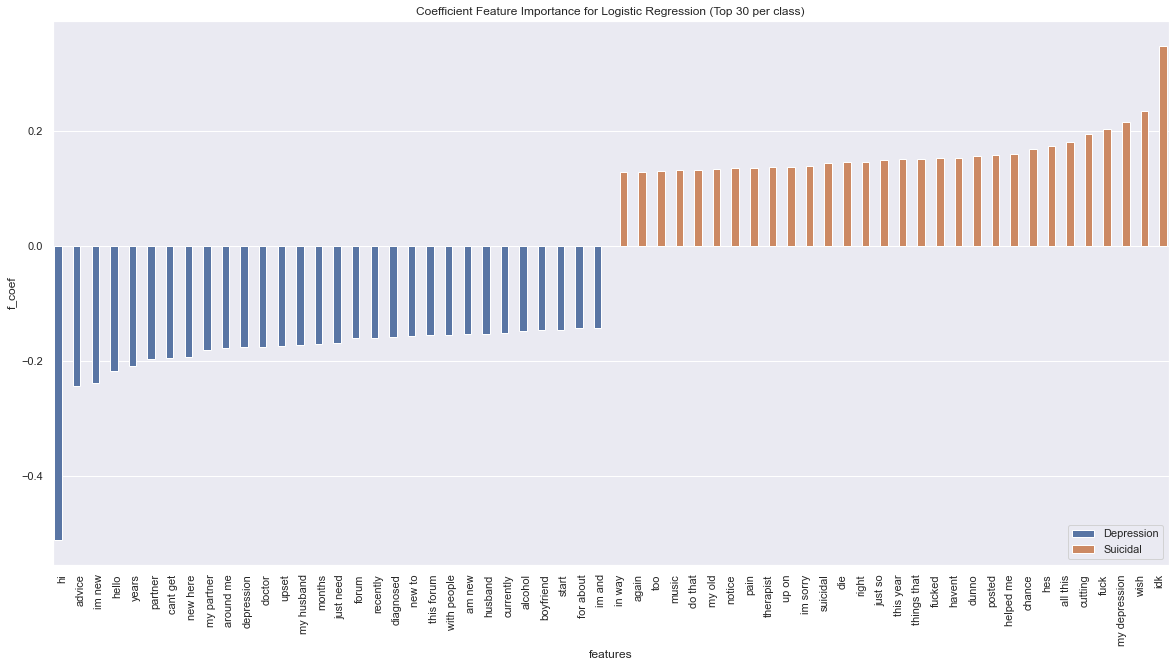

In [12]:
sns.set(rc={'figure.figsize':(20,10)})
colors = ['Suicidal' if c >= 0 else 'Depression' for c in top_60['f_coef']]
g = sns.barplot(
    x=top_60['features'],
    y=top_60['f_coef'],
    hue=colors,
    palette=sns.color_palette() 
)
plt.xticks(rotation=90)
plt.title('Coefficient Feature Importance for Logistic Regression (Top 30 per class)')
plt.show()

The plot above shows the top 30 coefficients for the sucidal and depressive class, and further confirms our theory that the way we speak can help understand the way we feel. 

Looking at the blue coefficients, the most important indicator of a user not being in the suicidal class was 'hi', additional strong indicators were 'my partner', 'my husband', 'boyfriend' potentially indicating a support system sorrounding the the author. Words like doctor and diagnosed relating to medical treatment may suggest that these users have more access to care. 

Looking at the red coefficients, they seem to tell a much darker story. The top indicator is simply 'idk' or I don't know, symbolizing a feeling of hopelesness. Words like 'wish', 'all this', and 'dunno' further contribute to this sentiment. Several words, such as 'cutting', 'pain' and 'die', show how much users are struggling. Several swear words are also part of these coefficients. 